<a href="https://colab.research.google.com/github/Pokemon-Catcher/pandasHomework/blob/master/Copy_of_02_02_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.2 Кластеризация. Баннеры.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

## Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 элементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет используя pandas `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [122]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np

Mounted at /content/drive/


In [123]:
df=pd.read_csv('/content/drive/My Drive/Data/checkins.csv.gz', na_values='?')

offices=pd.DataFrame(np.reshape([33.751277, -118.188740, 'Los Angeles',
25.867736, -80.324116, 'Miami',
51.503016, -0.075479, 'London',
52.378894, 4.885084, 'Amsterdam',
39.366487, 117.036146, 'Beijing',
-33.868457, 151.205134, 'Sydney'],(-1,3)),columns=['latitude','longitude','city'])


df.head()

,latitude,longitude
0,38.895112,-77.036366
1,33.800745,-84.410520
2,45.523452,-122.676207
3,40.764462,-111.904565
4,33.448377,-112.074037


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [13]:
from sklearn.cluster import MeanShift
import pickle

ms=None
try: #Мне надоело ждать 20 минут, каждый раз, поэтому я решил просто загружать всё из файла
  with open('/content/drive/My Drive/Data/file', 'rb') as f:
    pickle.load(f)
except FileNotFoundError:
  ms=MeanShift(bandwidth=0.1, n_jobs=-1).fit(df)
  with open('/content/drive/My Drive/Data/file', 'wb+') as f:
  f.write(pickle.dumps(ms))

FileNotFoundError: ignored

### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

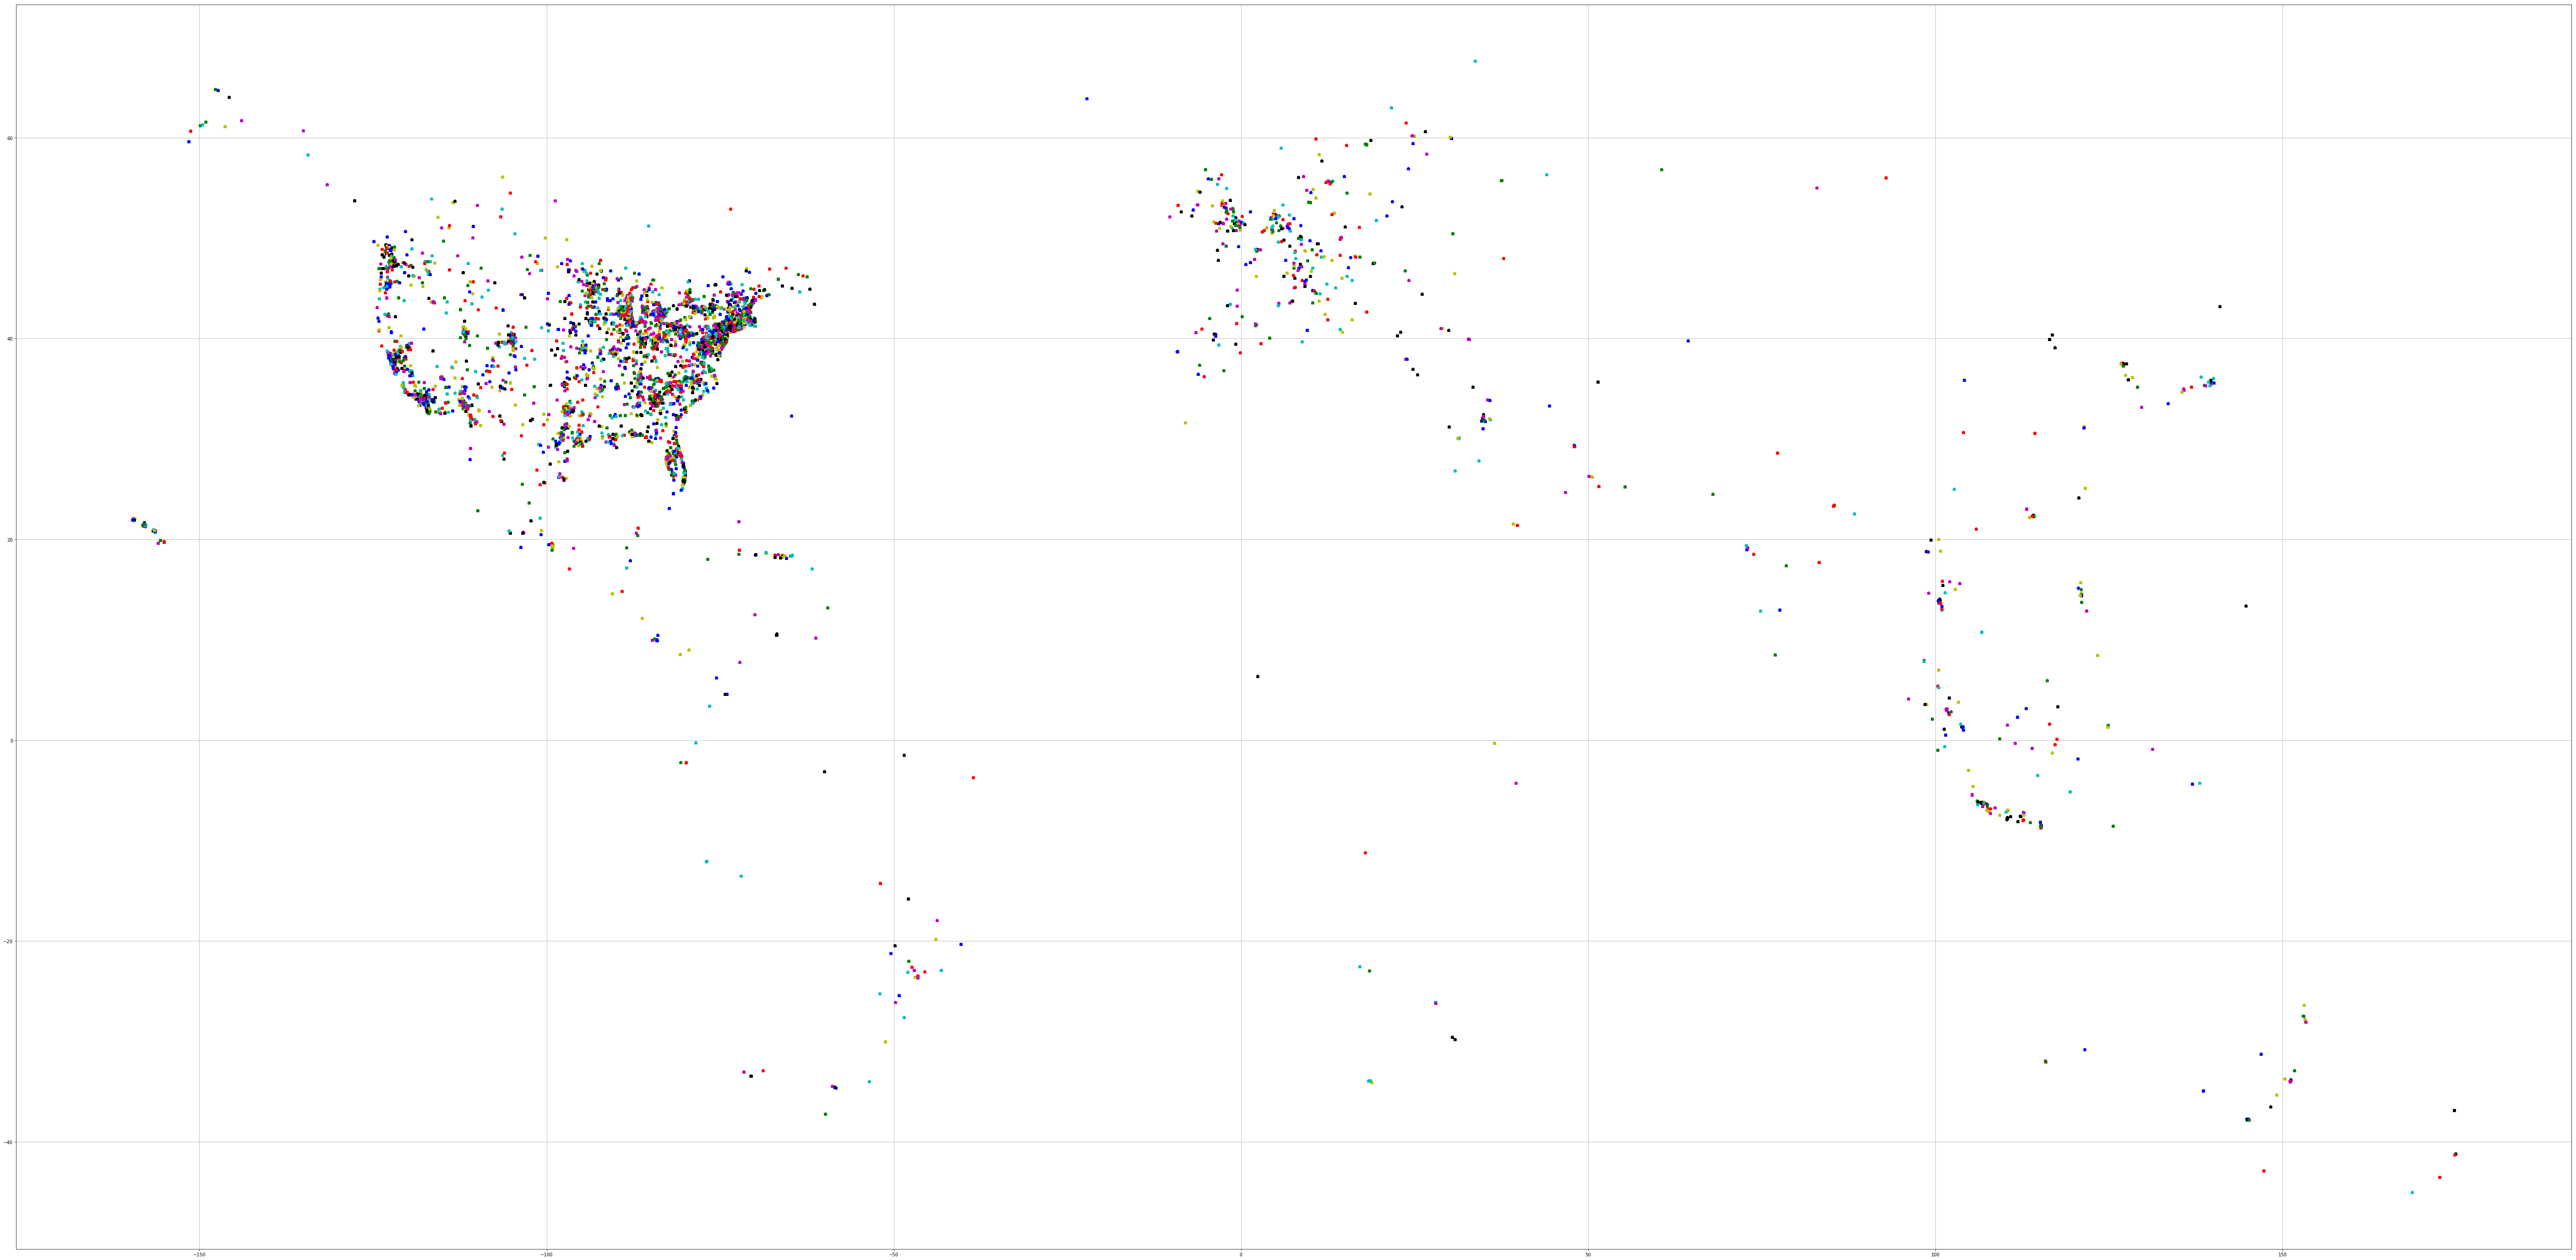

In [78]:
import matplotlib.pyplot as plt
from itertools import cycle

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(100, 50))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(df[my_members].longitude, df[my_members].latitude,'o'+col)
    plt.plot(cluster_center[1], cluster_center[0], '^'+col)
plt.grid(True)
plt.show()

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

In [0]:
from itertools import groupby

labels_group=groupby(labels_unique, lambda x: (labels == x).sum())
labels_len=[]
for key, group in labels_group:
  if(key>15):
    labels_len.append(key)
len(labels_len)

446

###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

In [137]:
from geopy.distance import vincenty

#offices.groupby(['name']).apply(lambda x: .km)
df=pd.DataFrame([])
for index, i in offices.iterrows():
  arr=np.apply_along_axis(lambda row: np.append(row,vincenty(row, [i.latitude,i.longitude])),1, cluster_centers)
  arr=arr[arr[:,2].argsort()][:20]
  df[i.city]=tuple(arr)
df #Амстердам совпал

,Los Angeles,Miami,London,Amsterdam,Beijing,Sydney)
0,"(33.8098779552631, -118.14892380690813, 7.4732...","(25.8456722642857, -80.31889059642857, 2.49983...","(51.502991260887086, -0.12553728870967767, 3.4...","(52.37296399032261, 4.892317222580647, 0.82344...","(39.121079, 117.21438899999998, 31.29016222944...","(-33.86063042857143, 151.20477592857145, 0.868..."
1,"(33.8883253427586, -118.04892817172427, 19.965...","(25.7858124199675, -80.2179380368254, 13.98950...","(51.426763288888885, -0.3037320666666667, 17.9...","(52.38850099999999, 4.633765466666666, 17.1454...","(39.90421400000001, 116.40741299999999, 80.483...","(-34.00190615, 151.12806905000002, 16.42788342..."
2,"(33.87298601157018, -118.36209114655645, 20.97...","(25.705349721052592, -80.28342873815798, 18.44...","(51.5741517, 0.1838708, 19.65777958334269 km)","(52.2644, 4.6347, 21.30201507649454 km)","(40.376322, 116.842992, 113.33527713547474 km)","(-33.952262899999994, 151.0321372, 18.50354855..."
3,"(33.97257482142858, -118.16837066666663, 24.61...","(26.010098249285683, -80.19999058571432, 20.08...","(51.506478766666675, -0.3651772666666666, 20.1...","(52.2738177, 5.1643425, 22.342684427499968 km)","(37.4562557, 126.7052062, 870.2201793845646 km)","(-33.71495460000001, 150.3114074, 84.500518522..."
4,"(33.81730643390889, -117.891249170958, 28.5096...","(26.138843786842077, -80.33434683684207, 30.05...","(51.49345570000001, 0.3529197, 29.768341860516...","(52.080058, 5.10513275, 36.493101166990314 km)","(37.5588652, 126.8029305, 875.232245554521 km)","(-32.8970039, 151.7005582, 117.19181326293565 km)"
5,"(33.98393587403844, -118.00740497307689, 30.78...","(26.120862658633104, -80.1589066802157, 32.558...","(51.75153, -0.333892, 32.93494597487684 km)","(52.132633, 5.291266, 38.989422351930436 km)","(37.56653499999998, 126.97796920000012, 889.85...","(-35.3080556, 149.12444440000004, 248.87029780..."
6,"(33.67430265976576, -117.85878926777275, 31.75...","(26.20058464102565, -80.250716125641, 37.60047...","(51.4307509, -0.5481531999999999, 33.816140028...","(52.156651, 5.388438, 42.33593638979223 km)","(37.26357270000001, 127.0286009, 903.984535270...","(-36.506376, 148.30120300000004, 394.422644225..."
7,"(34.06039755458241, -118.24870902659876, 34.73...","(25.4687224, -80.4775569, 46.81130628589912 km)","(51.23291010000001, -0.3297445, 34.87965585123...","(52.2224835, 5.4835625, 44.381129241369216 km)","(37.4449168, 127.1388684, 907.3041730047192 km)","(-31.2532183, 146.921099, 495.879298980032 km)"
8,"(34.03548695312116, -118.43899771946148, 39.11...","(26.35257116627905, -80.085278717442, 58.78754...","(51.1133388, -0.1829137, 43.99572616773495 km)","(51.974932, 4.9744262, 45.36271771995296 km)","(37.4912195, 127.4875607, 935.4494217393699 km)","(-28.067365500000005, 153.34310666666667, 674...."
9,"(33.65089599288026, -117.75207397281613, 41.98...","(26.48884247142857, -80.0700818714285, 73.3491...","(51.522751, -0.720209, 44.81143857665412 km)","(52.787747, 4.797934, 45.87838676184411 km)","(36.3504119, 127.3845475, 969.5348328520536 km)","(-37.7133771, 145.14891619999997, 693.80088262..."


Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 